Code for reproducing figure 3 plots for representational analyses of ANNs


Eleanor Holton 27/03/2025

In [16]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Get notebook's directory and find project root (transfer-interference directory)
try:
    # Try to get notebook path (works in Jupyter)
    notebook_path = Path(__file__).parent if '__file__' in globals() else Path.cwd()
except:
    notebook_path = Path.cwd()

# Navigate up to find project root (directory containing 'src' and 'data')
project_root = Path(notebook_path).resolve()
while not (project_root / 'src').exists() or not (project_root / 'data').exists():
    if project_root == project_root.parent:  
        # If we can't find it, assume we're in notebooks folder
        project_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
        break
    project_root = project_root.parent

# Add project root to Python path
sys.path.insert(0, str(project_root))

# Setup figure output path
figure_path = project_root / 'figures/figure3_anns'
os.makedirs(figure_path, exist_ok=True)

# Create matplotlib cache directory and clear font cache to pick up font changes
try:
    cache_dir = Path.home() / '.cache' / 'matplotlib'
    cache_dir.mkdir(parents=True, exist_ok=True)
    matplotlib.font_manager._load_fontmanager(try_read_cache=False)
except Exception as e:
    print(f"Note: Could not clear font cache: {e}")

from src.analysis import participant, ann, stats
from src.utils import figure_utils
from src.utils.figure_settings import schedule_colours, task_colours, cm_conv, med_fontsize, condition_order

import importlib
importlib.reload(ann)
importlib.reload(participant)
importlib.reload(figure_utils)
importlib.reload(stats)


<module 'src.analysis.stats' from '/Users/eleanorholton/Desktop/transfer-interference-project/src/analysis/stats.py'>

In [9]:
# Load data
participant_data = pd.read_csv(project_root / 'data/participants/trial_df.csv')
datafolder = (project_root / 'data/simulations/')
# Load data for different regimes
regime = 'rich_50'
results = {}

# Load ANN data
ann_folder = os.path.join(datafolder, regime)
ann_data = ann.load_ann_data(ann_folder)
    

In [10]:
n_sections = ann_data['near'][0]['predictions'].shape[0]  
n_itr = ann_data['near'][0]['predictions'].shape[1]  
n_itr 

subdat= participant_data.loc[participant_data['participant']=='study1_same_sub9',:]
a1 = subdat.query("task_section == 'A1' and feature_idx == 1 and block > 0")['rule_applied'].values
b = subdat.query("task_section == 'B' and feature_idx == 1 and block > 10")['rule_applied'].values
a2 = subdat.query("task_section == 'A2' and feature_idx == 1")['rule_applied'].values
len(b)


n_sections = ann_data['near'][0]['predictions'].shape[0]  
n_itr = ann_data['near'][0]['predictions'].shape[1]  
n_stim = 6  

# Create initial DataFrame with conditions
participants = []
conditions = []
for condition in ['near', 'far']:
    for i in range(len(ann_data[condition])):
        participants.append(str(ann_data[condition][i]['participant']))
        conditions.append(condition)

grouped_df = pd.DataFrame({
    'participant': participants,
    'condition': conditions
})

# Initialize columns
for section in ['A1', 'B', 'A2']:
    grouped_df[f'A_weight_{section}'] = np.nan
    grouped_df[f'kappa_{section}'] = np.nan

for s_idx, schedule_data in enumerate([ann_data['near'], ann_data['far']]):
    for subj in range(len(schedule_data)):
        # Calculate rules
        ruleA = np.arctan2(schedule_data[subj]['labels'][0,1,:][0], schedule_data[subj]['labels'][0,1,:][1]) - \
                np.arctan2(schedule_data[subj]['labels'][0,0,:][0], schedule_data[subj]['labels'][0,0,:][1])
        ruleB = np.arctan2(schedule_data[subj]['labels'][1,1,:][0], schedule_data[subj]['labels'][1,1,:][1]) - \
                np.arctan2(schedule_data[subj]['labels'][1,0,:][0], schedule_data[subj]['labels'][1,0,:][1])
        
        # Get responses for each section
        responses = {}
        for task_section_idx, section in enumerate(['A1', 'B', 'A2']):
            summer_radians = np.arctan2(schedule_data[subj]['predictions'][task_section_idx,::2,0],
                                      schedule_data[subj]['predictions'][task_section_idx,::2,1])
            winter_radians = np.arctan2(schedule_data[subj]['predictions'][task_section_idx,1::2,2],
                                      schedule_data[subj]['predictions'][task_section_idx,1::2,3])
            
            response_angle = winter_radians - summer_radians
            #response_angle = basic.wrap_to_pi(response_angle) 

            # Each section, ANNs are trained on 100 iterations of participant training data (10 blocks x 6 stimuli x 100 iterations)
            # To match human data length i.e. 60 per section, we take first six stimuli every 10 iterations
            responses[section] = np.concatenate([response_angle[i:i+n_stim] 
                                             for i in range(0,n_itr,100)])

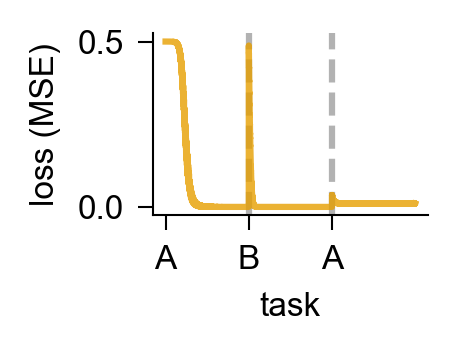

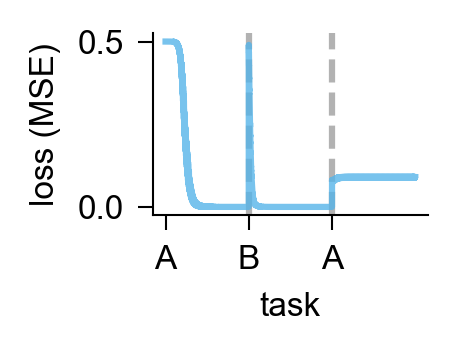

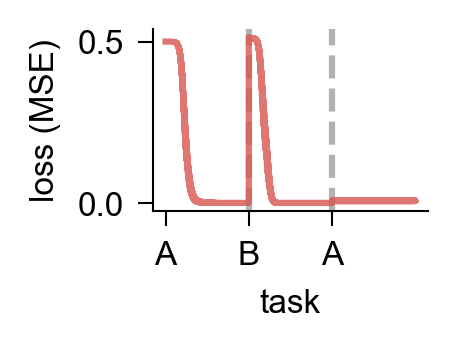

In [11]:
# Analyze loss curves
results = ann.analyze_training_loss(ann_data)
    
    
for schedule, fig_idx in zip(['same', 'near', 'far'],['B','C','D']):
    fig, ax = figure_utils.plot_loss_curves(ann_data, schedule, schedule_colours)
    fig.savefig(
        os.path.join(figure_path, f'fig3{fig_idx}_loss_curves_{schedule}.png'),
        dpi=500, 
        bbox_inches="tight"
    )
        #plt.close(fig)

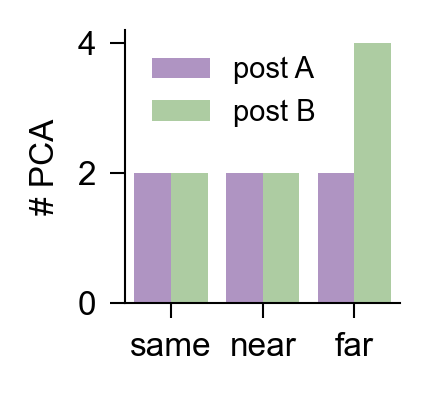

In [12]:
# Compute PCA components
agg_df_long = ann.compute_pca_components(ann_data)

# Create and save the plot
fig, ax = figure_utils.plot_pca_components(agg_df_long, task_colours)
fig.savefig(os.path.join(figure_path, f'fig3E_pca_{regime}.png'), 
            dpi=500, bbox_inches="tight")


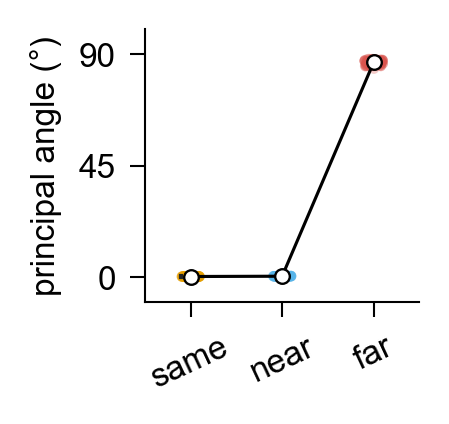

In [15]:
pa_df = ann.get_principal_angles(ann_data)

# 4. re-use transfer plotting function
fig,ax=figure_utils.plot_transfer(pa_df, 'principal_angle_between', ['same','near','far'], ylabel='principal angle (°)', xlim=(-0.5, 2.5), ylim=(-10,100), yticks=np.arange(0,91,45), schedule_colours=schedule_colours, p_values=np.nan, addtests=0,markersize=3,scatter=False,figsize=[3*cm_conv,3*cm_conv])
fig.savefig(os.path.join(figure_path, f'fig3I_principal_angle_{regime}.png'), 
            dpi=500, bbox_inches="tight")

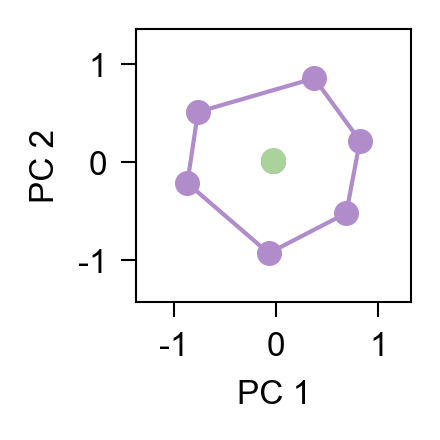

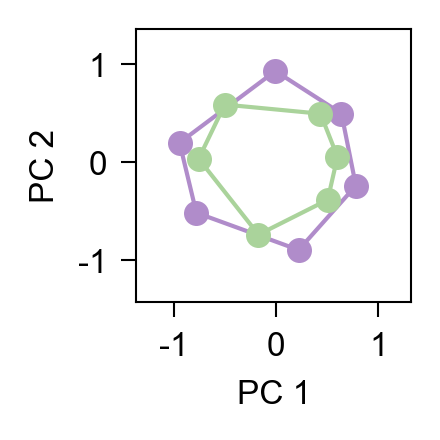

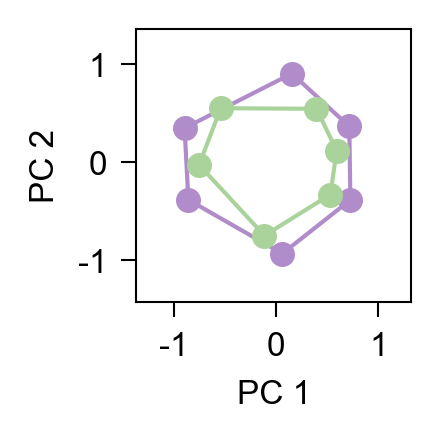

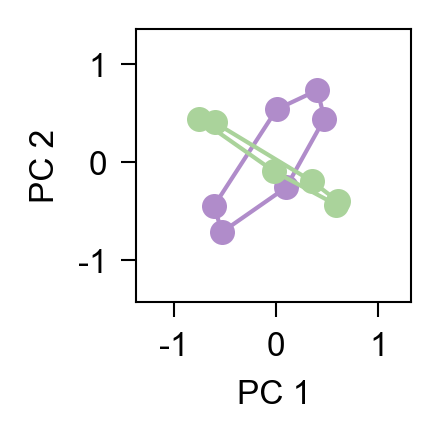

In [14]:
# Analyse hidden geometry of single subject

geom_results = np.load(project_root / 'data/simulations//geom_results_rich_50.npz')

hiddens_postA, same_hiddens_postB, near_hiddens_postB, far_hiddens_postB = ann.get_hiddens(geom_results)

# Perform PCA with respect to Task A
pca, _ = ann.prepare_pca_single_task(hiddens_postA)

# Plot hidden layer post Task A
A_hidden_2d_pca = ann.project_onto_pca(pca, hiddens_postA)
lims = figure_utils.get_axis_limits(A_hidden_2d_pca)

fig, ax = plt.subplots(figsize=[3 * cm_conv, 3 * cm_conv])
figure_utils.plot_split_stim(ax, A_hidden_2d_pca, task_colours, lims)
fig.savefig(os.path.join(figure_path, f'supp_A_geom_{regime}.png'), 
            dpi=500, bbox_inches="tight")

# Plot hidden layer post Task B for each condition
for idx, (hiddens_postB, cond,letter) in enumerate(zip([same_hiddens_postB, near_hiddens_postB, far_hiddens_postB], ['same', 'near', 'far'],['F','G','H'])):
    pca, _ = ann.prepare_pca_single_task(hiddens_postB)
    B_hidden_2d_pca = ann.project_onto_pca(pca, hiddens_postB)
    fig, ax = plt.subplots(figsize=[3 * cm_conv, 3 * cm_conv])
    figure_utils.plot_split_stim(ax, B_hidden_2d_pca, task_colours, lims)
    fig.savefig(os.path.join(figure_path, f'fig3_{letter}_geom_{regime}.png'), 
            dpi=500, bbox_inches="tight")

